In [1]:
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pacmap
import umap
import trimap

from scipy.stats import chisquare, chi2_contingency, pearsonr
from scipy.stats import kendalltau,spearmanr, weightedtau, theilslopes, wilcoxon, ttest_rel
from scipy.spatial import distance
import dcor

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness

%matplotlib inline

In [2]:

def sigmoid(x):
    #return np.tanh(x)
    return 1/(1+np.exp(-x))

def sigmoid_log(x):
    return sigmoid(np.log(x))

### load in data

In [3]:
celldyn_full = pd.read_csv("L:/laupodteam/AIOS/Huibert-Jan/Celldynclustering/Data/data_no_c_s_45.csv")

In [4]:
meas_columns = [c for c in celldyn_full.columns if 'c_b' in c]
mode_columns = [c for c in celldyn_full.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn_full.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn_full.columns if 'c_s_' in c.lower()]

### define preprocessing and model

In [5]:
droplist = ['c_b_wvf', 'c_b_bnd', 'c_b_ig', 'c_b_vlym', 'c_b_blst', 'c_b_pblst',
            'c_b_nrbc', 'c_b_pbnd', 'c_b_pig', 'c_b_pvlym', 'c_b_pnrbc']
sl_list = ['c_b_bnd', 'c_b_ig', 'c_b_vlym', 'c_b_blst', 'c_b_pblst',
            'c_b_nrbc', 'c_b_pbnd', 'c_b_pig', 'c_b_pvlym', 'c_b_pnrbc']

final_columns = list(set(meas_columns)-set(droplist))


q_scaler = FunctionTransformer(func=lambda x: np.maximum(np.quantile(x,0.001), np.minimum(np.quantile(x, 0.999), x)))
sl_scaler = FunctionTransformer(func=sigmoid_log)
wvf_scaler = FunctionTransformer(func=lambda x: np.maximum(0.90,(np.minimum(1, x))))

transformer_list = [('wvf_scaler', wvf_scaler, ['c_b_wvf']),
                    ('q_scaler', q_scaler, final_columns),
                    ('sl_scaler', sl_scaler, sl_list)]

pre_transformer = ColumnTransformer(transformer_list)


In [6]:
sample_df = celldyn_full.sample(50000).reset_index()

reduce_dim = 10


embedder_full = PCA(n_components = reduce_dim)
le_pipe = Pipeline([('scaler_1', pre_transformer),                    
                    ('scaler_2', StandardScaler()),
                    ('embedder', embedder_full)])
le_pipe.fit(sample_df[meas_columns])
transformed_data = le_pipe.transform(sample_df[meas_columns])

### check embedding

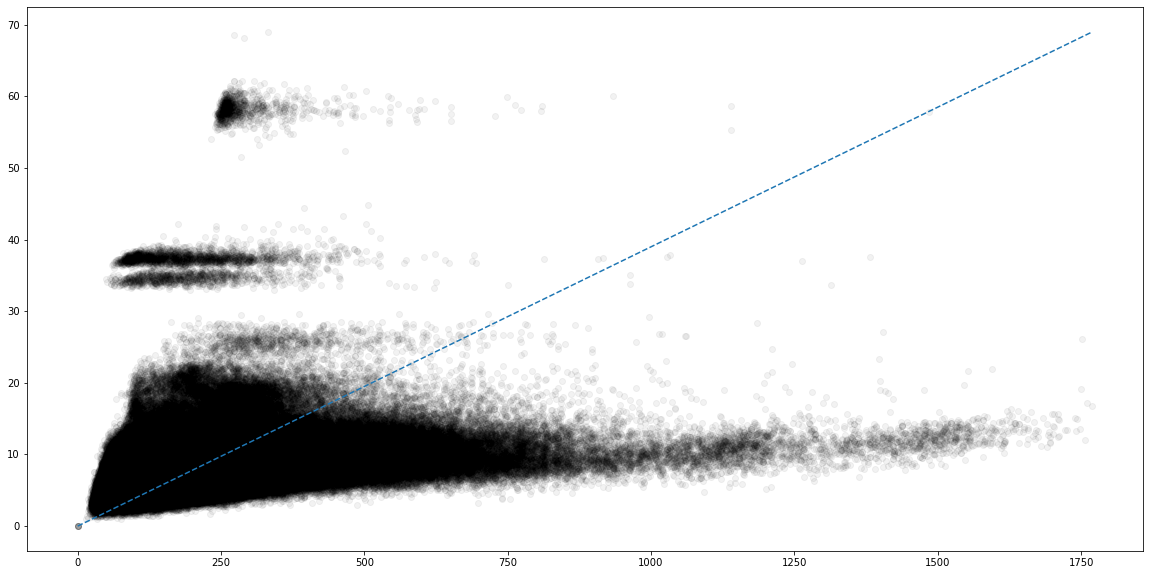

In [11]:
sample_selection = np.random.randint(0,50000,1000)
dist_before = distance.pdist(sample_df.reset_index(drop = True).loc[sample_selection,meas_columns])
dist_after = distance.pdist(transformed_data[sample_selection,:])


plt.figure(figsize = (20,10))
plt.scatter(dist_before,dist_after, alpha = 0.05,c ='black')
mx,my = max(dist_before), max(dist_after)
plt.plot([0,mx],[0,my],ls = "--")

In [12]:
from sklearn.metrics import rand_score, adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cluster import KMeans

In [13]:
clusterer_embedding = KMeans(n_clusters = 5)
clusterer_embedding.fit(transformed_data)

KMeans(n_clusters=5)

In [14]:
clusterer_org_dat = KMeans(n_clusters = 5)
clusterer_org_dat.fit(StandardScaler().fit_transform(pre_transformer.fit_transform(sample_df[meas_columns])))

KMeans(n_clusters=5)

In [15]:
r_score =rand_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)
ar_score = adjusted_rand_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)
mi_score = adjusted_mutual_info_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)

In [16]:
ch_score1 = calinski_harabasz_score(sample_df[meas_columns], clusterer_org_dat.labels_)
ch_score2 = calinski_harabasz_score(transformed_data, clusterer_embedding.labels_)

db_score1 = davies_bouldin_score(sample_df[meas_columns], clusterer_org_dat.labels_)
db_score2 = davies_bouldin_score(transformed_data, clusterer_embedding.labels_)

In [17]:
dist_preservation_overall = dcor.distance_correlation(dist_before, dist_after)

In [19]:
print("Distance preservation overall", dist_preservation_overall)
print("Intra-distance trustworthiness", trustworthiness(sample_df[meas_columns], transformed_data))
print("Rand score", r_score)
print("Adjusted Rand score", ar_score)
print("Adjusted MI score", mi_score)
print("Calinski-Harabasz ratio, lower than 1 means better clustering for embedding", ch_score1/ch_score2)
print("David-Bouldin ratio, higher than 1 means better clustering for embedding", db_score1/db_score2)

Distance preservation overall 0.41340118511773366
Intra-distance trustworthiness 0.8701371397023524
Rand score 0.9865083205664114
Adjusted Rand score 0.9712412410695294
Adjusted MI score 0.9358765626405627
Calinski-Harabasz ratio, lower than 1 means better clustering for embedding 0.5011636636597038
David-Bouldin ratio, higher than 1 means better clustering for embedding 1.7129610453046893


In [24]:
plot_df = pd.DataFrame(data=transformed_data, columns=[f'd_{i}' for i in range(reduce_dim)], index=sample_df.index)
plot_df = plot_df.join(sample_df[mode_columns+alrt_columns])
plot_df['k_means']  = clusterer_embedding.labels_

plot_df['has_alrt'] = np.where(np.sum(plot_df[alrt_columns],axis = 1) >0.5,1,0)
#reduce_dim = min([6, reduce_dim])
num_rows = int(np.ceil((reduce_dim)**2/3))

In [ ]:
#reduce_dim = min([6, reduce_dim])
num_rows = int(np.ceil((reduce_dim)**2/3))
fig, ax = plt.subplots(ncols=3, nrows=num_rows, figsize=(18, 5*num_rows))
k = 0
for ki in range(reduce_dim):
    for kj in range(reduce_dim): 
        i = int(k/3)
        j = k%3
        if num_rows > 1:
            sns.scatterplot(data=plot_df.sample(2500), x='d_'+str(ki), y='d_'+str(kj), ax=ax[i,j], 
                            hue='has_alrt', alpha=0.5)
        else:
            sns.scatterplot(data=plot_df.sample(2500), x='d_'+str(ki), y='d_'+str(kj), ax=ax[k], 
                            hue='has_alrt', alpha=0.5)
        k += 1

### start with clustering, then embedding


instead of the other way around

In [7]:
transformed_data = le_pipe.fit_transform(celldyn_full[meas_columns]) # final_columns


In [ ]:
from hdbscan import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=5,min_samples = 250,metric='manhattan')
clusterer.fit(celldyn_full[meas_columns],)





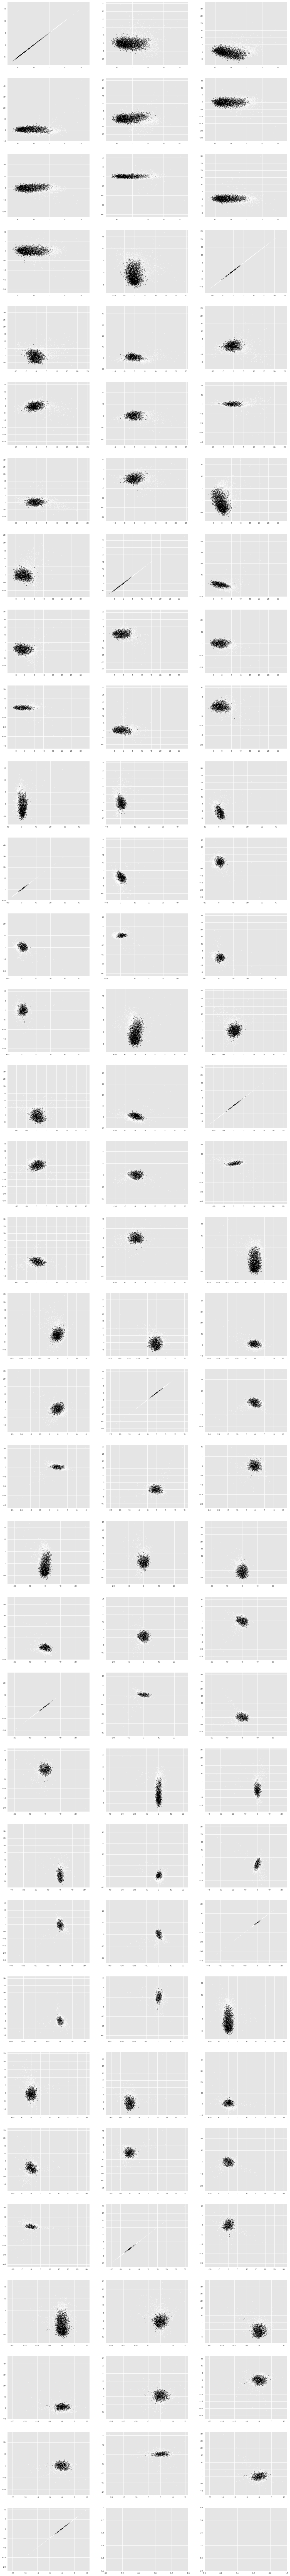

In [27]:
plt.style.use('seaborn-paper')
num_rows = int(np.ceil(10**2/3))
fig, ax = plt.subplots(ncols=3, nrows=num_rows, figsize=(18, 5*num_rows))
k = 0
plot_data = np.random.choice(transformed_data.shape[0], size=10000, replace=False)
for ki in range(reduce_dim):
    for kj in range(reduce_dim): 
        i = int(k/3)
        j = k%3
        if num_rows > 1:
            ax[i,j].scatter(transformed_data[plot_data,ki],transformed_data[plot_data,kj], alpha=0.5,s = 3,c = clusterer.labels_.astype(float)[plot_data])
        else:
            ax[k].scatter(transformed_data[plot_data,ki],transformed_data[plot_data,kj], alpha=0.5)
        k += 1


In [23]:
from collections import Counter


Counter(clusterer.labels_)

Counter({-1: 517934, 0: 1073603, 1: 23})